# Housing Prices Prediction
## Problem Statement
> **Can we use machine learning to help prospective home buyers and sellers in King County evaluate the market value of a house?**

### Problem Understanding
Typically in the process of buying or selling a house, a home owner would hire a real estate agent to make an appraisal of the market value of a house. This appraisal then helps them decide on the best listing price of a property. Such valuations would typically be based on certain factors like the size of the house, and other indicators of value like pools, and garages.

#### King County 
![](https://www.mapsofworld.com/usa/states/washington/maps/king-wa-county-map.jpg)
King County is located in the US State of Washington. It is on the west coast of the US. 

Key Geographical Parts of King County Include:
- City of Seattle (largest city in Washington)
- Lake Washington (largest lake in KC)
- Lake Sammamish
- Lake Union 
- Airports (located in the middle and south part of KC)
- Cascade Range (a series of mountains on the east side of King County)
- Vashon Island (connected to West Seattle)
- Mercer Island

Hence our objectives would be to:
- create a model that can supplement a real estate appraisal to help home buyers/sellers in King County make better decisions
- extract insights as to how important different factors affect housing prices in King County.
## Evaluation Metrics
### Benchmark
While the US does not appear to set any margin of error for a real estate appraisal, UK case law says that the margin of error of the appraised value from the actual value should not generally exceed 15%. The typical margin of error is 5% for simple residential property valuations.

Hence, for our model to be reliable, we would expect a margin of error of less than 15% from the actual value. One way to interpret this would be a Mean Absolute Percentage Error of less than 15%. 

## Importing Libraries

In [15]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
sns.set()

# Util
from custom_util import outlierDetection, removeOutliers


# Experimental
from sklearn.experimental import enable_halving_search_cv, enable_hist_gradient_boosting

# Base Classes
from sklearn.base import BaseEstimator, TransformerMixin

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_validate, KFold
from yellowbrick.model_selection import learning_curve, feature_importances
from yellowbrick.regressor import residuals_plot
from sklearn.inspection import permutation_importance

# Data Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer


# Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

# Hyperparameter Tuning
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV
from yellowbrick.model_selection import validation_curve

# Feature Selection
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest, SequentialFeatureSelector, chi2, mutual_info_classif

# Random State Instance. Using a RandomState instance sets the seed for the RNG generator. This allows for reproducible results, while still ensuring robust results (e.g. not overfitting to the random state)
random_state = np.random.RandomState(42) # also note that for cross validation, the splitter will be passed an integer while the actual estimator will be passed the random state instance, as recommended by scikit-learn documentation.

## Data Ingestion

In [16]:
house_df = pd.read_csv("kc_house_data.csv")
house_df.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

## Data Exploration

### Dataset Description
This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

### Dataset Dictionary
| Column | Data Type | Remarks |
|---|---|---|
| id | Integer (Nominal) | Unique ID for each house |
| date | Date | Need to convert to dt format from string |
| price | Float (Continuous) | Target Variable. Price of House in USD |
| bedrooms | Integer (Discrete) | No. of Bedrooms in the House |
| bathrooms | Float (Discrete) | Quarter of a bathroom is a bathroom with a toilet only, no shower |
| sqft_living | Float (Continuous) | Square footage of the inside of the house |
| sqft_lot | Float (Continuous) | Square footage of the entire home, including the exterior |
| floors | Float (Discrete) | Includes split level home|
| waterfront | Integer (Boolean) | Is the property a waterfront property? |
| view | Integer (Ordinal) | On a scale of 0 to 4, how good is the view of the property |
| condition | Integer (Ordinal) | On a scale of 1 to 5, how good is the condition of the house |
| grade | Integer (Ordinal) | On a scale of 1 to 13, how good is the quality of the house |
| sqft_above | Float (Continuous) | Square footage of the parts of the house above the first floor |
| sqft_basement | Float (Continuous) | Square footage of the basement of the house |
| yr_built | Integer (Discrete) | Year of Construction |
| yr_renovated | Integer (Discrete) | Year of latest renovation |
| zipcode | Integer (Nominal) | zipcode of house |
| lat | Float (Continuous) | Latitude (North-South)|
| long | Float (Continuous) | Longitude (East-West)|
| sqft_living15 | Float (Continuous)|Average Sqft_Living for nearest 15 houses |
| sqft_lot15 | Float (Continuous) | Average Sqft_lot for nearest 15 houses |

### Objectives
- How many rows and how many columns are there?
- What does the target variable look like?
- What is the distribution of the numerical columns?
- What is the distribution of the categorical columns?
- Are there any missing values and how many of them are there?
- Are there any outliers in the data?
- How are the various columns correlated to the target variable?


In [17]:
house_eda = house_df.copy() # Make a copy the dataframe to do eda on

### Univariate Analysis

#### Descriptive Analysis

In [18]:
house_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

- There are 21613 rows and 21 columns.
- There appear to be no missing values in the data.
- `date` has an incorrect data type. It should be represented as a date instead of a string.

In [19]:
house_eda.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.161300e+04  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean   4.580302e+09  5.400881e+05      3.370842      2.114757   2079.899736   
std    2.876566e+09  3.671272e+05      0.930062      0.770163    918.440897   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.123049e+09  3.219500e+05      3.000000      1.750000   1427.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  21613.000000   
mean   1.510697e+04      1.494309      0.007542      0.234303      3.409430   
std    4.142051e+04      0.539989      0.086517      0.766318      0.650743   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.040000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.618000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.068800e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above  sqft_basement      yr_built  yr_renovated  \
count  21613.000000  21613.000000   21613.000000  21613.000000  21613.000000   
mean       7.656873   1788.390691     291.509045   1971.005136     84.402258   
std        1.175459    828.090978     442.575043     29.373411    401.679240   
min        1.000000    290.000000       0.000000   1900.000000      0.000000   
25%        7.000000   1190.000000       0.000000   1951.000000      0.000000   
50%        7.000000   1560.000000       0.000000   1975.000000      0.000000   
75%        8.000000   2210.000000     560.000000   1997.000000      0.000000   
max       13.000000   9410.000000    4820.000000   2015.000000   2015.000000   

            zipcode           lat          long  sqft_living15     sqft_lot15  
count  21613.000000  21613.000000  21613.000000   21613.000000   21613.000000  
mean   98077.939805     47.560053   -122.213896    1986.552492   12768.455652  
std       53.505026      0.138564      0.140828     685.391304   27304.179631  
min    98001.000000     47.155900   -122.519000     399.000000     651.000000  
25%    98033.000000     47.471000   -122.328000    1490.000000    5100.000000  
50%    98065.000000     47.571800   -122.230000    1840.000000    7620.000000  
75%    98118.000000     47.678000   -122.125000    2360.000000   10083.000000  
max    98199.000000     47.777600   -121.315000    6210.000000  871200.000000

- Housing Prices are likely to be positively skewed with many outliers, as the max price of the houses is much larger than the upper quartile.
- Similarly, living space and lot space also has a positively skewed distribution.
- Most houses are not waterfront properties (at least 75%)
- Most houses have 0 basement space. 
- At least 75% of houses have never been renovated.

#### Target Variable
The target variable we are trying to predict is the price in USD of the house.

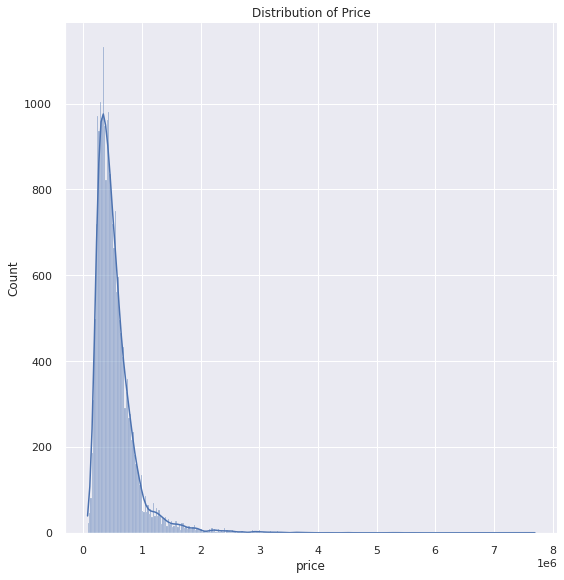

In [20]:
sns.displot(data=house_eda, x="price", kde=True, height = 8)
plt.title("Distribution of Price")
plt.show()

We note that the distribution of the price is heavily positively skewed. Most houses are less than $100K USD, but some houses cost more than a million. This suggests that the mean and standard deviation of the price might not be the best descriptor of it's distribution.

In [21]:
price_median = house_eda["price"].median() 
price_iqr = house_eda["price"].quantile(.75) - house_eda["price"].quantile(.25) 
print(f"Median Price: ${price_median}, Price IQR: ${price_iqr}")

Median Price: $450000.0, Price IQR: $323050.0


When looking at the median price, we note that while it is still quite high, the prices are more reasonable.

Shape Before Removing Outliers: (21613, 1)
Shape After Removing Outliers: (20467, 1)


<AxesSubplot:xlabel='price'>

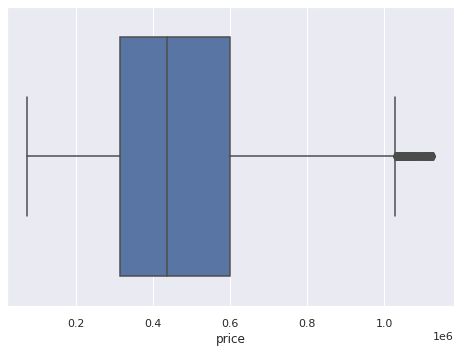

In [22]:
sns.boxplot(x="price", data = removeOutliers(house_eda[["price"]]))

When the extreme values are removed, we can see the typical distribution more clearly.

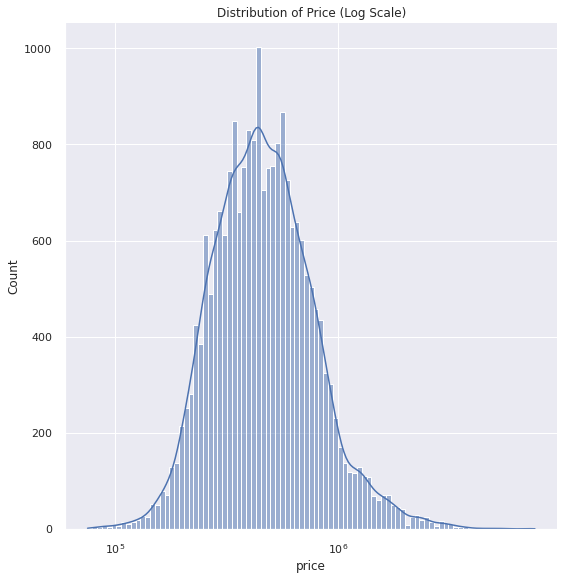

In [23]:
sns.displot(data=house_eda, x="price", kde=True, log_scale=True,height = 8)
plt.title("Distribution of Price (Log Scale)")
plt.show()

When plotted on a log scale, the prices appear to follow a normal distribution. This suggests that prices in King County follow a log normal distribution, suggesting that transformation of the target variable to accurately reflect this might improve the performance of the model.

#### Numerical Features

In [24]:
numerical_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15', 'lat', 'long']

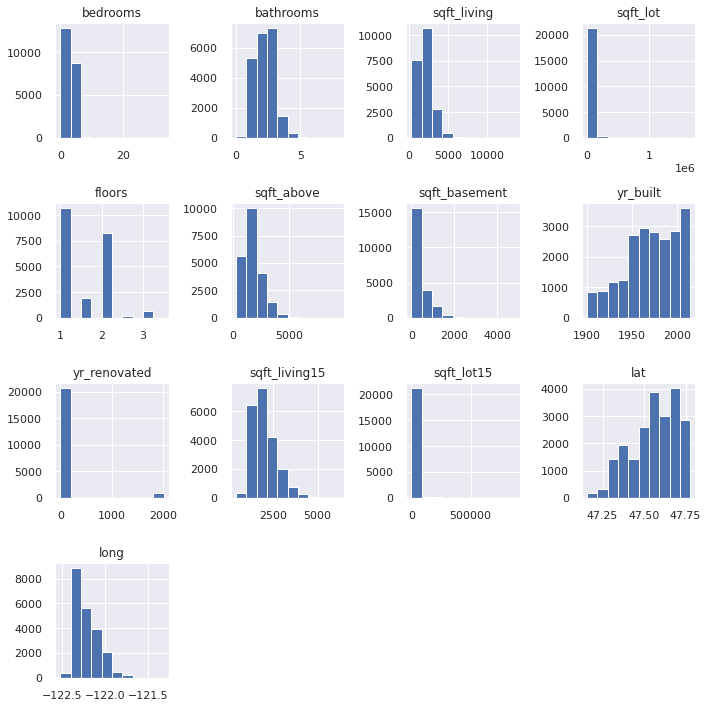

In [25]:
house_eda[numerical_features].hist(figsize=(10, 10))
plt.tight_layout()
plt.show()

Based on the histograms, we see that
- Living area appears to be positively skewed
- Most houses have never been renovated, as suggested by most having a year of 0 (a prefilled indicator value)
- Most houses were constructed after 1950
- Most houses have very similar and small lot sizes. 

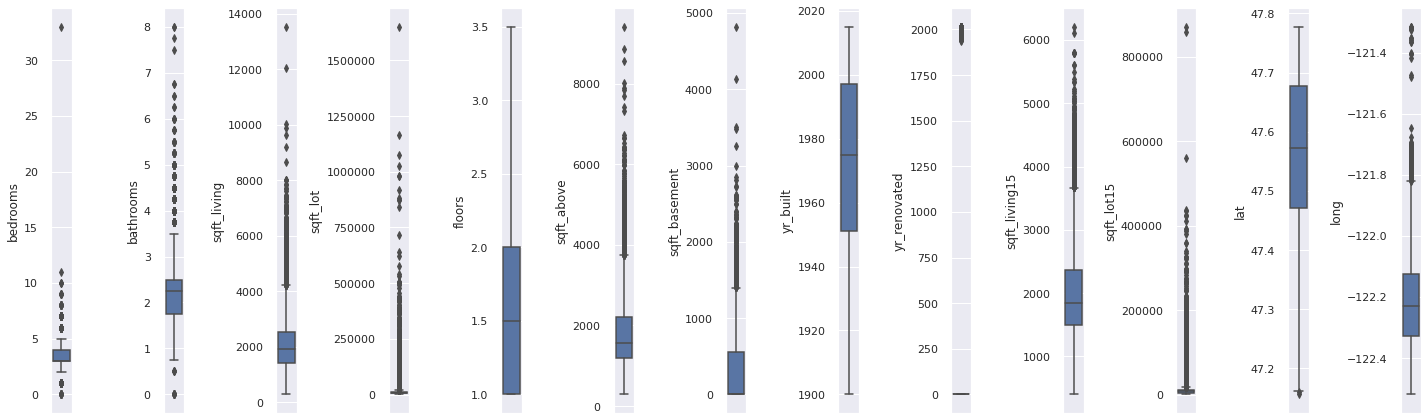

In [26]:
fig, ax = plt.subplots(1, len(numerical_features), figsize=(20, 6), tight_layout = True)

for idx, col in enumerate(numerical_features):
    ax[idx].ticklabel_format(useOffset=False, style='plain') # do not use scientific notation
    sns.boxplot(data = house_eda, y=col, ax = ax[idx])
fig.show()

From the boxplots we note that
- There is one extreme outlier house with more than 30 bedrooms. 
- While most houses have low lot sizes, a few have extremely large lot sizes, presumably located in more rural areas, but this will have to be investigated further.

In [27]:
house_eda["age"] = house_eda["date"].dt.year - house_eda["yr_built"]
house_eda["age"].hist()
plt.title("Distribution of Property Age")
plt.show()


AttributeError: Can only use .dt accessor with datetimelike values

Most houses are between 20 and 60 years of age. The distribution of age is positively skewed, with a few houses being very old (>100 years old)

In [45]:
def cat_plot(df, features, figsize = (10, 20)):
    fig, ax = plt.subplots(len(features), 1, figsize= figsize, tight_layout = True)
    for idx, feature in enumerate(features):
        ax[idx].set_title("Counts of " + feature)
        # counts = df[feature].value_counts()
        sns.countplot(data = df, y = feature, ax = ax[idx])
    return fig

We want to investigate values of discrete data further.

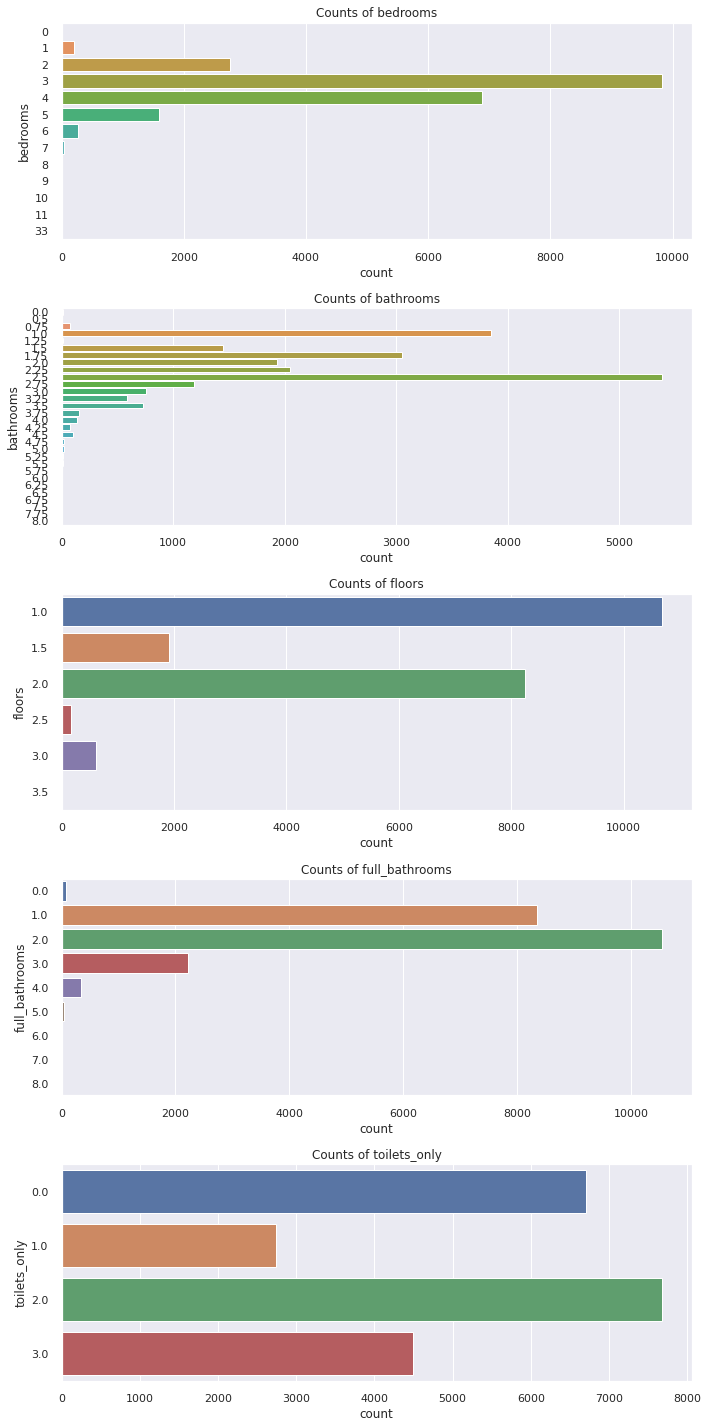

In [48]:
house_eda["full_bathrooms"] = house_eda["bathrooms"].apply(lambda x : np.floor(x))
house_eda["toilets_only"] = (house_eda["bathrooms"] - house_eda["full_bathrooms"]) / 0.25
count_data = ["bedrooms", "bathrooms", "floors", "full_bathrooms", "toilets_only"]
fig = cat_plot(house_eda, count_data)

Most houses have:
- 3 Bedrooms
- 2 Full Bathrooms (shower)
- 2 Toilets
- 1 Floor

We note that some houses are split level properties.

Strangely we also see a few houses apparently have zero bedrooms and zero bathrooms. These must be investigated later on.

#### Categorical Features

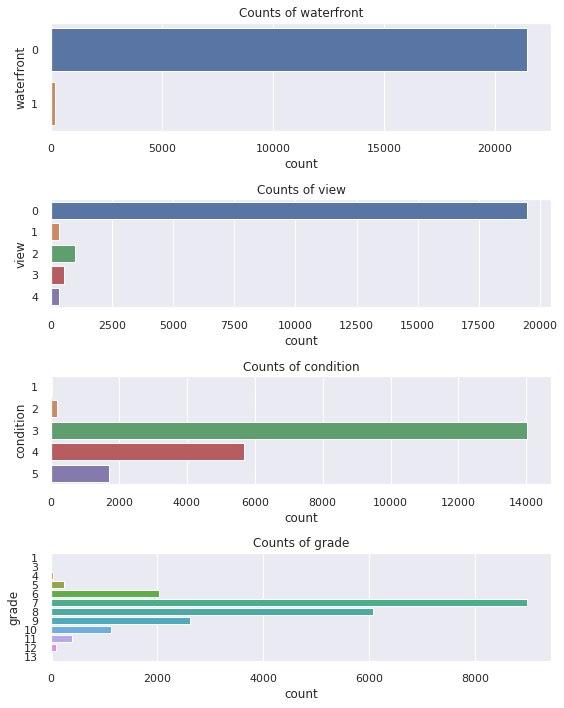

In [52]:
categorical_features = ['waterfront', 'view', 'condition', 'grade']
fig = cat_plot(house_eda, categorical_features, figsize=(8, 10))

Most houses:
- are not waterfront properties
- have a poor view 
- are of average condition
- have a grade of 7 (average quality)

#### Time Series Features

In [17]:
house_eda["date"] = pd.to_datetime(house_eda["date"])
house_eda["month"] = house_eda["date"].dt.month

<AxesSubplot:xlabel='month', ylabel='count'>

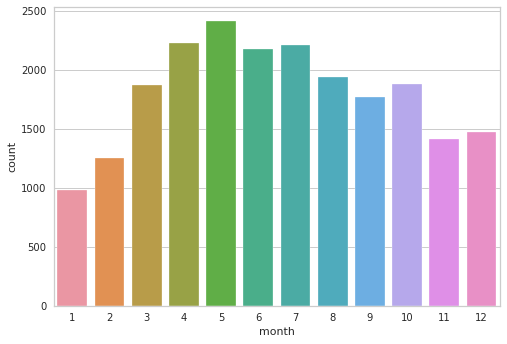

In [23]:
sns.countplot(x="month", data=house_eda)

Most houses are sold between April (4th month) and August (8th Month). The least houses are sold in January and Feburary.

#### Investigating Outliers & Anomalies

We start by investigating those properties which are an outlier in terms of their number of bedrooms.

Outliers in Series (First 5)
             id             date     price  bedrooms  bathrooms  sqft_living  \
154  7920100045  20140516T000000  350000.0         1       1.00          700   
209  6300000550  20140717T000000  464000.0         6       3.00         2300   
232  9264902050  20141121T000000  315000.0         6       2.75         2940   
239  5152100060  20140529T000000  472000.0         6       2.50         4410   
264  2123039032  20141027T000000  369900.0         1       0.75          760   

     sqft_lot  floors  waterfront  view  ...  sqft_basement  yr_built  \
154      5100     1.0           0     0  ...              0      1942   
209      3404     2.0           0     0  ...            700      1920   
232      7350     1.0           0     0  ...           1160      1978   
239     14034     1.0           0     2  ...           2060      1965   
264     10079     1.0           1     4  ...              0      1936   

     yr_renovated  zipcode      lat     long  sqft_

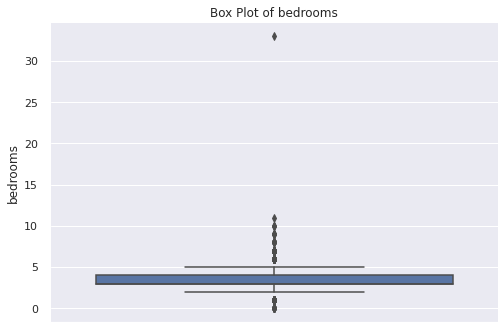

id             date      price  bedrooms  bathrooms  \
9854   7849202190  20141223T000000   235000.0         0       0.00   
14423  9543000205  20150413T000000   139950.0         0       0.00   
875    6306400140  20140612T000000  1095000.0         0       0.00   
8477   2569500210  20141117T000000   339950.0         0       2.50   
3467   1453602309  20140805T000000   288000.0         0       1.50   
...           ...              ...        ...       ...        ...   
13314   627300145  20140814T000000  1148000.0        10       5.25   
19254  8812401450  20141229T000000   660000.0        10       3.00   
15161  5566100170  20141029T000000   650000.0        10       2.00   
8757   1773100755  20140821T000000   520000.0        11       3.00   
15870  2402100895  20140625T000000   640000.0        33       1.75   

       sqft_living  sqft_lot  floors  waterfront  view  ...  sqft_basement  \
9854          1470      4800     2.0           0     0  ...              0   
14423          844      4269     1.0           0     0  ...              0   
875           3064      4764     3.5           0     2  ...              0   
8477          2290      8319     2.0           0     0  ...              0   
3467          1430      1650     3.0           0     0  ...              0   
...            ...       ...     ...         ...   ...  ...            ...   
13314         4590     10920     1.0           0     2  ...           2090   
19254         2920      3745     2.0           0     0  ...           1060   
15161         3610     11914     2.0           0     0  ...            600   
8757          3000      4960     2.0           0     0  ...            600   
15870         1620      6000     1.0           0     0  ...            580   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
9854       1996             0    98065  47.5265 -121.828           1060   
14423      1913             0    98001  47.2781 -122.250           1380   
875        1990             0    98102  47.6362 -122.322           2360   
8477       1985             0    98042  47.3473 -122.151           2500   
3467       1999             0    98125  47.7222 -122.290           1430   
...         ...           ...      ...      ...      ...            ...   
13314      2008             0    98004  47.5861 -122.113           2730   
19254      1913             0    98105  47.6635 -122.320           1810   
15161      1958             0    98006  47.5705 -122.175           2040   
8757       1918          1999    98106  47.5560 -122.363           1420   
15870      1947             0    98103  47.6878 -122.331           1330   

       sqft_lot15  full_bathrooms  toilets_only  
9854         7200             0.0           0.0  
14423        9600             0.0           0.0  
875          4000             0.0           0.0  
8477         8751             2.0           2.0  
3467         1650             1.0           2.0  
...           ...             ...           ...  
13314       10400             5.0           1.0  
19254        3745             3.0           0.0  
15161       11914             2.0           0.0  
8757         4960             3.0           0.0  
15870        4700             1.0           3.0  

[546 rows x 23 columns]

In [56]:
outlierDetection(house_eda, "bedrooms")

Earlier, we noted those houses with no bedrooms and bathrooms were suspicious. It turns out from research that these places actually correspond to empty lots which are bing sold. Hence, they are not data entry errors, but represent a specific type of property. Since they are outliers, we may want to consider removing them from training to improve any future models.

### Bivariate Analysis

In [18]:
house_corr = house_eda.drop(['id', 'zipcode', 'date'], axis=1).corr()


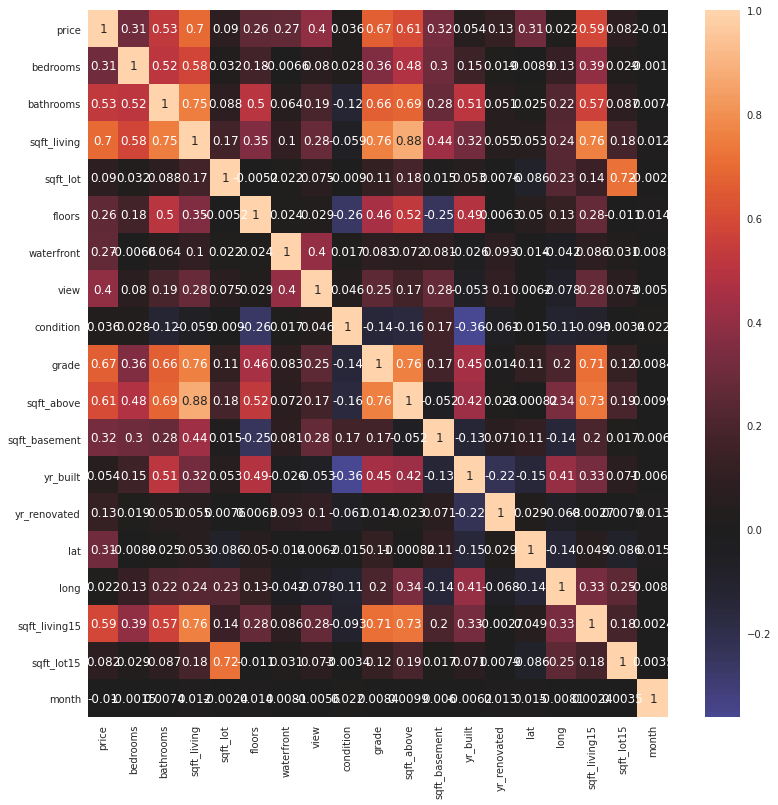

In [19]:
fig, ax = plt.subplots(figsize=(13, 13))
sns.heatmap(house_corr, ax = ax, annot = True, center = 0)
fig.show()

#### Geographical Analysis

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


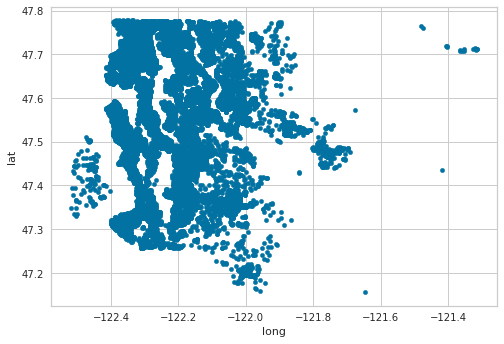

In [21]:
geographical_features = ["lat", "long"]
house_eda.plot(kind='scatter', x='long', y='lat')
plt.show()

##### Is there a rural-urban divide? (Which parts of the city have more value)

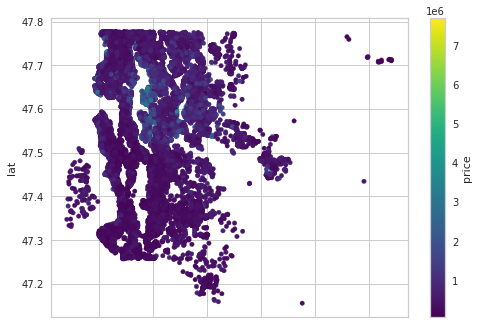

In [28]:
house_eda.plot(kind='scatter', x='long', y='lat', c='price', cmap='viridis')
plt.show()

##### Do waterfront properties hold more value?

In [1]:
house_eda.plot(kind='scatter', x='long', y='lat', c='waterfront', cmap='viridis')
plt.show()

NameError: name 'house_eda' is not defined

## Data Preparation

### Separate Target & Features

### Create Hold-Out Set

### Data Pre-processing Pipeline

## Modelling
### Evaluation Methodology

### Baseline Model (Mean Value Predictor)

## Model Improvement

### Attempting Different Methods of Feature Scaling

### Transforming the Target Variable

### Converting Latitute and Longitude to ECEF Coordinates

### Considering Proximity to Waterfront

### Adding Indicator Values (Feature Binning)

### Feature Selection

### Hyperparameter Tuning

## Final Model

## Model Evaluation

### Residual Plot

### Feature Importances

## Conclusion